In [2]:
import numpy as np
from math import sqrt as sqrt
from statistics import mean as mean
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


# Problem Statement

Simulate a full path of a DTMC for an appropriate inventory model, and use the Monte Carlo method to estimate its corresponding discounted value function. Compare the resulting values with a neural network, and on the mean squared errors.

Inventory Model: Consider a perishable product with a maximum lifetime of L periods. Thus, at the end of period t, there may be leftover inventory of this product with a remaining lifetime j such that $ 1 <= j <= L - 1 $. Any leftover items with 0 remaining life is considered "expired" and will be disposed. Let $X_tj$ be the amount of inventory with remaining lifetime less or equal to j after the "expired items" are disposed, then the system state by the end of the period $t$ is $X_t = (X_{t1}, X_{t2},...,X_{t,L-1})^4$. $X_{tj}-X_{t,j-1}$ is the number of items with remaining lifetime exactly $j \in {2,3,...,L-1}$.
By the end of period $t-1$, after disposing expired items, an order for $Q-X_{t-1,L-1}$ units of new items is placed. At the beginning of period $t$, $Q-X_{t-1,L-1}$ units of new items arrive, bringing the total inventory level to Q. The variable cost $c_v$ per unit is paid when new inventory arrives. A random demand $D_t$ then occurs and is met immediately as much as possible with inventory from oldest to newest. Demand across different periods is assumed to be i.i.d. and follows Poisson distribution with mean $\lambda$. Unmet demand is lost. At the end of period $t$, expired invenory is disposed at cost $c_d$ per unit, and leftover inventory incurs a holding cost $h$ per unit. 
In our model, the selling price $c_p = 1$, variable cost $c_v = 0.4$, disposal cost $c_d=0.1$, holding cost $h=0.1$, and the demand rate is $\lambda=17$. 

## Sampling a full DTMC path for 20 states and 20*10^3 time intervals

In [3]:
# Function state_subset

# Required parameters
# K: number of states selected in subset
# T: total amount of time intervals
# x0n: initial state value of the amount of items with remaining lifetime less than or equal to n

# Returns
# subset: subset of K values, taken from larger state set of T time intervals

def state_subset(K, T, x01, x02, x03, x04, x05, x06):
    Q = 90
    L = 7
    x1 = x01
    x2 = x02
    x3 = x03
    x4 = x04
    x5 = x05
    x6 = x06

    states = np.empty([0,6], dtype = int) 

    for t in range(T):
        D = np.random.poisson(17)
        # simulating next state using DTMC property
        x1 = max(x2 - x1 - max(D - x1,0),0) 
        x2 = max(x3 - x2 - max(D - x2,0),0) + x1
        x3 = max(x4 - x3 - max(D - x3,0),0) + x2
        x4 = max(x5 - x4 - max(D - x4,0),0) + x3 
        x5 = max(x6 - x5 - max(D - x5,0),0) + x4
        x6 = max((Q - x6) - max(D - x6,0),0) + x5
        state = np.array([[x1, x2, x3, x4, x5, x6]])
        states = np.row_stack((states, state))
    
    subset = np.empty([0,6], dtype = int)
    for k in range(K):
        index = (k+1)*(10**3)-1
        state = states[index]
        subset = np.row_stack((subset, state))
    return subset

# generating full path of DTMC where K = 20
K = 20 
T = (10**3) * K 
subset20 = state_subset(K, T, 0,0,0,0,0,0)
print('Subset of states where K = 20')
print(subset20)

Subset of states where K = 20
[[ 0  0 15 31 48 69]
 [ 0  0 15 31 58 68]
 [11 24 37 50 63 75]
 [ 0 12 31 39 54 69]
 [ 0  0 12 41 57 75]
 [ 0  8 28 48 63 75]
 [ 0  0 20 38 63 76]
 [ 0  0 14 32 52 76]
 [ 0  0 14 32 48 69]
 [ 5 20 37 53 68 78]
 [ 0 12 27 40 58 76]
 [ 0 16 34 54 71 78]
 [ 0  0 12 29 41 63]
 [ 0  0 20 43 61 76]
 [11 24 36 51 60 73]
 [ 0  0 14 33 50 67]
 [ 0 11 28 45 55 73]
 [ 0  6 26 40 58 73]
 [ 0  0 10 30 49 74]
 [ 0  0 16 34 53 75]]


## Sampling a DTMC with 200 states and 200*10^3 time intervals

In [4]:
K = 200
T = (10**3) * K 

# generating full path of DTMC where K = 200
subset200 = state_subset(K, T,0,0,0,0,0,0)

print('Subset of states where K = 200')
print(subset200)

Subset of states where K = 200
[[ 0  7 19 39 55 77]
 [ 0  0 11 34 52 69]
 [ 0 11 28 42 63 80]
 ...
 [ 0  5 20 38 55 74]
 [ 0 11 24 39 53 68]
 [ 0  8 20 42 53 73]]


## Calculate the estimated expected profit and its confidence interval for 20 states, over 100 episodes

In [5]:
# Function get_values

# Required parameters 
# K: number of states selected in subset
# N: amount of times to run Monte-Carlo method with initial kth initial state
# T: amount of time intervals from inital kth state 
# subset: the subset to get initial states from 
# disp: True or False, depending on whether you want values to be displayed or not

# Returns 
# est_values: estimated values from Monte Carlo method 
# epsilons: epsilon values corresponding to the estimated values from the Monte Carlo method 


def get_values(K, N, T, subset, disp):
    Q = 90
    L = 7
    cp = 1.0
    cv = 0.4
    cd = 0.1
    h = 0.1
    b = 0.8
    
    values = np.array([[]])
    est_values = np.array([[]])
    epsilons = np.array([[]])
    
    for k in range(K):
    
        for n in range(N):
            x1 = subset[k][0]
            x2 = subset[k][1]
            x3 = subset[k][2]
            x4 = subset[k][3]
            x5 = subset[k][4]
            x6 = subset[k][5]
            v = 0
        
            for t in range(T):
                D = np.random.poisson(17)
                # Discounted value function
                revenue = cp*D
                order_cost = cv*(Q-x6)
                disposal_cost = cd*max(x1-D, 0)

                x1 = max(x2 - x1 - max(D - x1,0),0) 
                x2 = max(x3 - x2 - max(D - x2,0),0) + x1
                x3 = max(x4 - x3 - max(D - x3,0),0) + x2
                x4 = max(x5 - x4 - max(D - x4,0),0) + x3 
                x5 = max(x6 - x5 - max(D - x5,0),0) + x4
                x6 = max((Q - x6) - max(D - x6,0),0) + x5
            
                hold_cost = h*x6
                profit = revenue - order_cost - disposal_cost - hold_cost
                v = v + (b**t)*profit
            
            values = np.append(values,v)

        value_mean = mean(values)
        est_values = np.append(est_values, value_mean)
        epsilon = 1.96*np.std(values)/sqrt(N)
        epsilons = np.append(epsilons, epsilon)
        values =  np.array([[]])
        
        if disp:
            # Display each state, estimated. value, 95% level CI 
            print('Initial state k =',(k+1), subset20[k])
            print('Estimated value:', value_mean)
            # CI Interval
            print('Confidence interval: [', (value_mean - epsilon), ',', (value_mean + epsilon), '] \n')

    return est_values, epsilons

K = 20
N = 100
T = 100 
# Length of episode t = 100
# We want to use a T value where we can approximate beta^T = 0 as best and as reasonable as possible.
    
values = get_values(K, N, T, subset20, True)

Initial state k = 1 [ 0  0 15 31 48 69]
Estimated value: 13.154527256970121
Confidence interval: [ 12.05684391356044 , 14.252210600379803 ] 

Initial state k = 2 [ 0  0 15 31 58 68]
Estimated value: 11.946919721352455
Confidence interval: [ 10.897777584782146 , 12.996061857922763 ] 

Initial state k = 3 [11 24 37 50 63 75]
Estimated value: 14.512107045726175
Confidence interval: [ 13.429798949906186 , 15.594415141546165 ] 

Initial state k = 4 [ 0 12 31 39 54 69]
Estimated value: 12.73351818904854
Confidence interval: [ 11.747893368214001 , 13.71914300988308 ] 

Initial state k = 5 [ 0  0 12 41 57 75]
Estimated value: 14.528710739917605
Confidence interval: [ 13.624966411151934 , 15.432455068683275 ] 

Initial state k = 6 [ 0  8 28 48 63 75]
Estimated value: 15.276378933901587
Confidence interval: [ 14.16987039932482 , 16.382887468478355 ] 

Initial state k = 7 [ 0  0 20 38 63 76]
Estimated value: 15.579394251642283
Confidence interval: [ 14.485024838826309 , 16.673763664458257 ] 

Ini

## Plot the estimated expected profit with its 95% confidence interval for 20 states, 100 time intervals, over 100 episodes

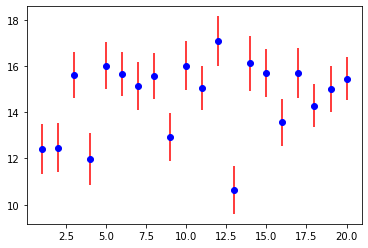

In [6]:
K = 20
N = 100
T = 100

values = get_values(K, N, T, subset20, False)
est_values = values[0]
epsilons = values[1]

for k in range(20):
    plt.errorbar((k+1), est_values[k], yerr = epsilons[k], ecolor = 'red')
    plt.plot(k+1, est_values[k], 'bo')

## Plot the estimated expected profit with its 95% confidence interval for 20 states, 1000 time intervals, over 1000 episodes

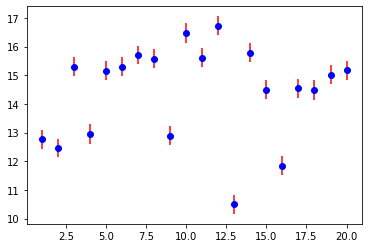

In [7]:
K = 20
N = 1000 
T = 1000

values20 = get_values(K, N, T, subset20, False)
est_values20 = values20[0]
epsilons20 = values20[1]

for k in range(20):
    plt.errorbar((k+1), est_values20[k], yerr = epsilons20[k], ecolor = 'red')
    plt.plot(k+1, est_values20[k], 'bo')

## Plot the estimated expected profit with its 95% confidence interval for 200 states, 100 time intervals, over 100 episodes

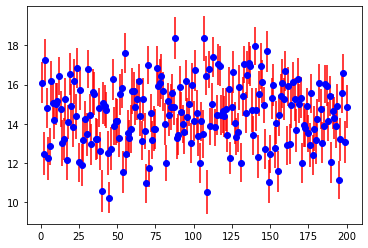

In [8]:
K = 200
N = 100
T = 100

values = get_values(K, N, T, subset200, False)
est_values = values[0]
epsilons = values[1]

for k in range(K):
    plt.errorbar((k+1), est_values[k], yerr = epsilons[k], ecolor = 'red')
    plt.plot(k+1, est_values[k], 'bo')

## Plot the estimated expected profit with its 95% confidence interval for 200 states, 1000 time intervals, over 1000 episodes

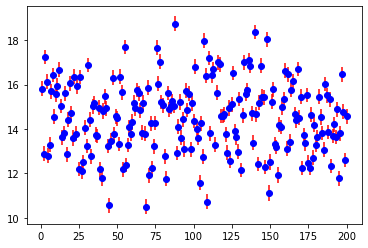

In [9]:
K = 200
N = 1000
T = 100

values200 = get_values(K, N, T, subset200, False)
est_values200 = values200[0]
epsilons200 = values200[1]

for k in range(K):
    plt.errorbar((k+1), est_values200[k], yerr = epsilons200[k], ecolor = 'red')
    plt.plot(k+1, est_values200[k], 'bo')

## Set Up Neural Network

In [10]:
class MyNeuralNetwork:
    def __init__ (self, input_dimension):
        self.model = Sequential()
        self.model.add(Dense(5, input_dim = input_dimension, activation = 'relu'))
        self.model.add(Dense(5, activation = 'relu'))
        self.model.add(Dense(1, activation = 'linear'))
        self.model.compile(loss = 'mean_squared_error', optimizer = 'adam')

## Extract the Dataset

In [11]:
N = 1000
t = 100
x_train = subset200
x_test = [[10,20,30,40,50,80]]
y_train = est_values200

y_values =  get_values(1, N, t, x_test, False)
y_test = y_values[0]
y_epsilons = y_values[1]

## Normalize Dataset Using Scalar

In [12]:
class Scaler:
    def __init__ (self, x, y):
        self.x_mean = np.mean(x, axis = 0)
        self.y_mean = np.mean(y)
        self.x_std = np.std(x, axis = 0)
        self.y_std = np.std(y)
    
    def get_x (self):
        return self.x_std, self.x_mean
    
    def get_y (self):
        return self.y_std, self.y_mean

In [13]:
normalizer = Scaler(x_train, y_train)
std_x, mean_x = normalizer.get_x()
x_train_norm = (x_train - mean_x)/(std_x)
x_test_norm = (x_test - mean_x)/(std_x)
std_y, mean_y = normalizer.get_y()
y_train_norm = (y_train - mean_y)/(std_y)

## Train the Dataset Using Neural Network Model 

In [14]:
neural_network = MyNeuralNetwork(input_dimension = 6)
neural_network.model.fit(x_train_norm, y_train_norm, epochs = 100, batch_size = 8)

Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.7944
Epoch 2/100
200/200 [==============================] - 0s 161us/step - loss: 0.7538
Epoch 3/100
200/200 [==============================] - 0s 150us/step - loss: 0.7204
Epoch 4/100
200/200 [==============================] - 0s 153us/step - loss: 0.6895
Epoch 5/100
200/200 [==============================] - 0s 163us/step - loss: 0.6581
Epoch 6/100
200/200 [==============================] - 0s 163us/step - loss: 0.6287
Epoch 7/100
200/200 [==============================] - 0s 166us/step - loss: 0.5913
Epoch 8/100
200/200 [==============================] - 0s 169us/step - loss: 0.5537
Epoch 9/100
200/200 [==============================] - 0s 163us/step - loss: 0.5127
Epoch 10/100
200/200 [==============================] - 0s 171us/step - loss: 0.4667
Epoch 11/100
200/200 [==============================] - 0s 163us/step - loss: 0.3963
Epoch 12/100
200/200 [==============================] - 0s 165us/step - loss

## Identify whether the predicted value (v_tilda) falls within the 95% confidence interval of the value calculated with the Monte Carlo simulation (v_hat)

In [15]:
# Finding v_hat
v_hat = y_test[0]
# Predicting v_tilda
v_tilda =  (neural_network.model.predict(x_test_norm)* std_y + mean_y)[0][0]
# 95% CI for v_hat
CI = [v_hat - y_epsilons[0], v_hat +  y_epsilons[0]]

print('V_tilda:', v_tilda)
print('V_hat:', v_hat)
print('Confidence Interval of v_hat:', CI)

V_tilda: 17.026716
V_hat: 16.986212850714637
Confidence Interval of v_hat: [16.645323981782653, 17.32710171964662]


## Plot the predicted values (v_tilda) against the simulated values (v_hat) using 50 states, 50,000 time intervals, 1000 episodes

Red: v_hat, Blue: v_tilda


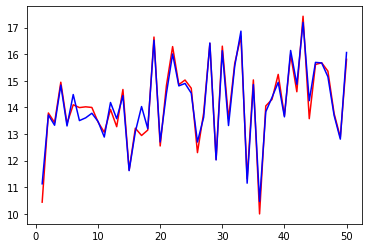

In [16]:
K = 50
T = 50000
N = 1000
t = 100

# Generating the testing datasets 
x_test = state_subset(K, T, 10, 20, 30, 40, 50, 80)
y_test = get_values(K, N, t, x_test, False)[0]

# Normalizing dataset using Scalar 
x_test_norm = (x_test - mean_x)/(std_x)

y_from_nn_norm = neural_network.model.predict(x_test_norm)
# Normalizing result and predicting v_hat (y_from_nn)
y_from_nn = y_from_nn_norm * std_y + mean_y

x_axis = list(range(1,K+1))


plt.plot(x_axis, y_test, color='red', label='v_hat')
plt.plot(x_axis, y_from_nn, color='blue', label = 'v_tilda')
print('Red: v_hat, Blue: v_tilda')


## Report the MSE for 20 vs 200 states and plot the predicted values (v_tilda) against the simulated values (v_hat)

Mean squared error for K = 20: 0.025086747157849976
Mean squared error for K = 200: 0.03371186316066718

 Just for personal interest
For K = 20: Red = vhat, Blue = vtilda
For K = 200: Orange = vhat, Green = vtilda


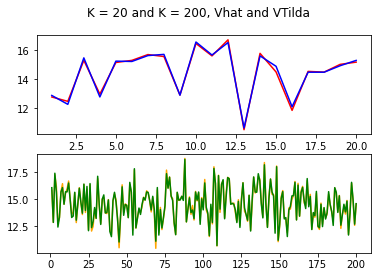

In [17]:
# Generating dataset for K = 20 
x_test20 = subset20 
y_test20 = est_values20

# Normalizing dataset
x_test_norm20 = (x_test20 - mean_x)/(std_x)

y_from_nn_norm20 = neural_network.model.predict(x_test_norm20)
# Normalizing result and predicting v_tilda (y_from_nn)
y_from_nn20 = y_from_nn_norm20 * std_y + mean_y

mse = mean_squared_error(y_test20, y_from_nn20)
print('Mean squared error for K = 20:', mse)

# Generating dataset for K = 200 
x_test200 = subset200 
y_test200 = est_values200

# Normalizing dataset
x_test_norm200 = (x_test200 - mean_x)/(std_x)

y_from_nn_norm200 = neural_network.model.predict(x_test_norm200)
# Normalizing result and predicting v_tilda (y_from_nn)
y_from_nn200 = y_from_nn_norm200 * std_y + mean_y

mse = mean_squared_error(y_test200, y_from_nn200)
print('Mean squared error for K = 200:', mse)

print('\n Just for personal interest')
print('For K = 20: Red = vhat, Blue = vtilda')
print('For K = 200: Orange = vhat, Green = vtilda')

fig, axs = plt.subplots(2)
fig.suptitle('K = 20 and K = 200, Vhat and VTilda')
axs[0].plot(list(range(1,20+1)), y_test20, color='red', label='v_hat20')
axs[0].plot(list(range(1,20+1)), y_from_nn20, color='blue', label = 'v_tilda20')
axs[1].plot(list(range(1,200+1)), y_test200, color='orange', label='v_hat200')
axs[1].plot(list(range(1,200+1)), y_from_nn200, color='green', label = 'v_tilda200')
